## EDA Single Sample Hourly

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append(os.getcwd() + "/..")
from utils import plot_correlogram
import feature_engineering as fe
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split
from utils import unpack_hierarchical_data_frame
from sklearn.pipeline import make_pipeline
%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')
random_state=123456789
np.random.seed(123456789)
from utils import plot_correlogram

## Read Data

In [2]:
meta, data =pd.read_pickle("../data/forecast_data_2020.p")

In [3]:
homes_indexes = data.columns.get_level_values(0).unique()

In [4]:
homes_indexes

Index(['854', '123', '852', '222', '484', '404', '992', '319', '583', '801',
       '987', '299', '640', '744', '241', '200', '441', '192', '621', '313',
       '464', '424', '993', '598', '514', '268', '745', '927', '945', '352',
       '980', '644', '683', '244', '677', '351', '118', '595', '255', '554',
       '318', '743', '947', '480', '219', '780', '909', '977', '272', '246',
       '521', '842', '267', '396', '290', '601', '901', '260', '618', '629',
       '238', '231', '875', '889', '340', '906', '604', '525', '460', '130',
       '363', '250', '666', '438', '986', '462', '188', '763', '923', '925',
       '822', '131', '456', '624', '827', '474', '859', '912', '194', '706',
       '522', '999', '113', '247', '657', '890', '412', '261', '957', '600'],
      dtype='object')

In [5]:
X=data["123"]
X["time"] = X.index

## Feature Engineering

### Target
Since at time step T we need to predict the value given at step T+1, but at step T
we only know values from step T-1 (make prediction on Wednesday about Constumption on Thursday, given known values of consumption only at Teusday, thus we need to shift by 2 * 24h = 48h

In [25]:
target = make_pipeline(fe.FeatureSelector('consumption'), fe.CalcShift(-48),fe.CastType(float))

### Current consumption
consumption at step T-1 won't require any shift

In [26]:
prev_consumption = make_pipeline(fe.FeatureSelector('consumption'), fe.CastType(float))

### Weather

Note all weather prediction for T+1 is given at step T, thus we need to shift for 24h

In [82]:
temperature = make_pipeline(fe.FeatureSelector('temperature'), fe.CalcShift(-24), fe.CastType(float))
humidity = make_pipeline(fe.FeatureSelector('humidity'), fe.CalcShift(-24), fe.CastType(float))
cloudiness = make_pipeline(fe.FeatureSelector('cloudiness'), fe.CalcShift(-24), fe.CastType(float))

### Extract Day Time

In [83]:
day_time =  make_pipeline(fe.FeatureSelector('time'), fe.ExtractDayTime())

### Extract season name from date

In [84]:
season = make_pipeline(fe.FeatureSelector('time'), fe.ExtractSeason())

### Combine Features

In [85]:
feature_union = fe.make_union(prev_consumption,
                              temperature,
                              humidity,
                              cloudiness,
                              day_time,
                              season,
                              target
                              )
feature_union

PandasFeatureUnion(transformer_list=[('pipeline-1',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption'))])),
                                     ('pipeline-2',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='temperature')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-24)),
                                                      ('casttype',
                                                       CastType())])),
                                     ('pipeline-3',
                                      Pipeline(steps=[('featureselector',
                                                       Feature...
                                                      ('extractdaytime',
                                                       ExtractDayTime())])),
                                     ('pipeline-6',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='time')),
                                                      ('extractseason',
                                                       ExtractSeason())])),
                                     ('pipeline-7',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption')),
                                                      ('casttype', CastType()),
                                                      ('calcshift',
                                                       CalcShift(new_feat_name='forward_consumption_48',
                                                                 shift_val=-48))]))])

## Transform

In [86]:
df = feature_union.fit_transform(X)

In [87]:
df.head()

,consumption,forward_temperature_24,forward_humidity_24,forward_cloudiness_24,day_time,season,forward_consumption_48
time,,,,,,,
2020-01-01 00:00:00,4.127000000000,5.64,80.0,100.0,0,Winter,1.332
2020-01-01 01:00:00,4.148000000000,5.23,83.0,100.0,1,Winter,3.709
2020-01-01 02:00:00,3.828000000000,5.21,83.0,100.0,2,Winter,4.330
2020-01-01 03:00:00,4.375000000000,5.09,84.0,100.0,3,Winter,4.141
2020-01-01 04:00:00,4.622000000000,4.96,85.0,99.0,4,Winter,2.471


## EDA Univariate Target

###  Distribution

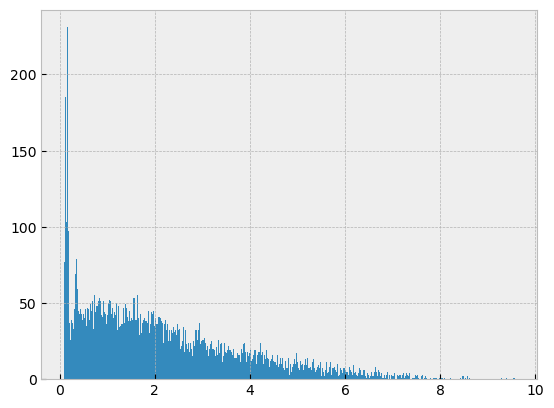

In [37]:
plt.hist(df["forward_consumption_48"], bins = 500)
plt.show()

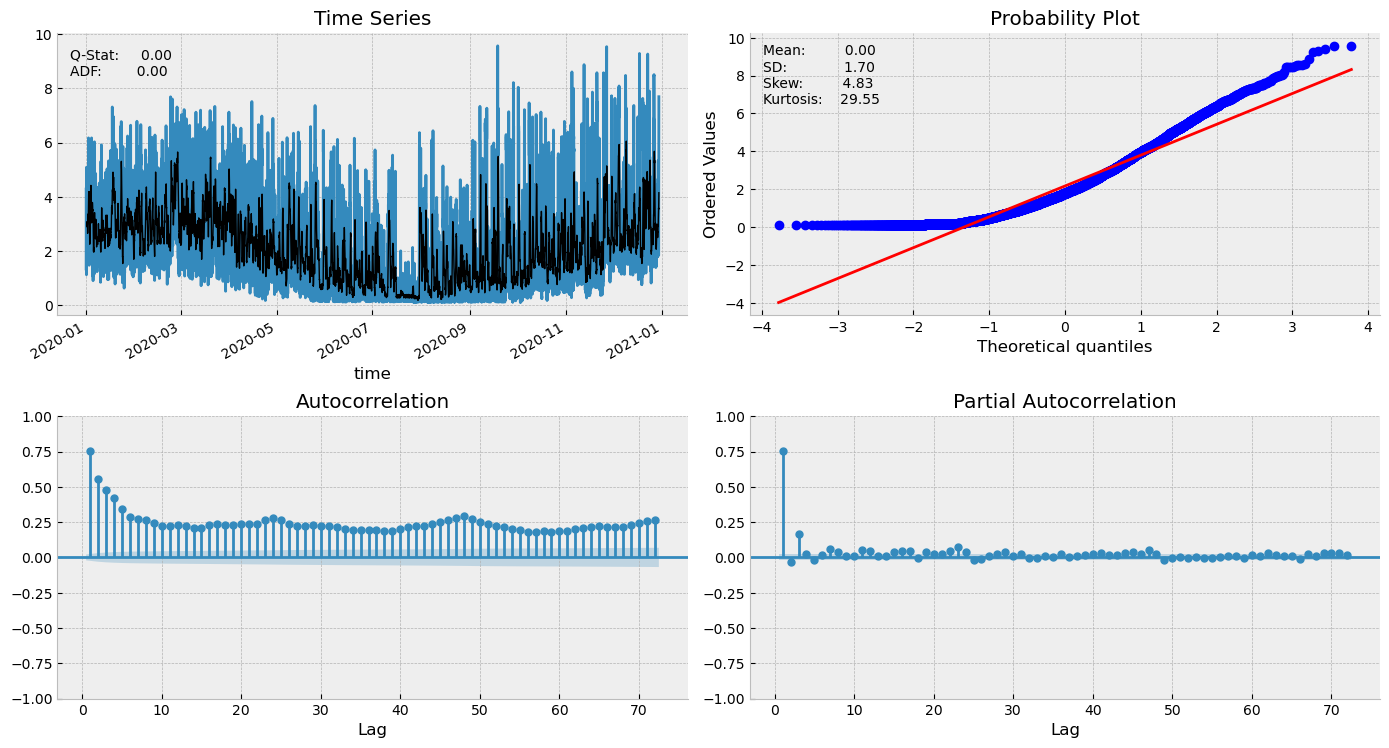

In [42]:
plot_correlogram(df["forward_consumption_48"], lags = 72)

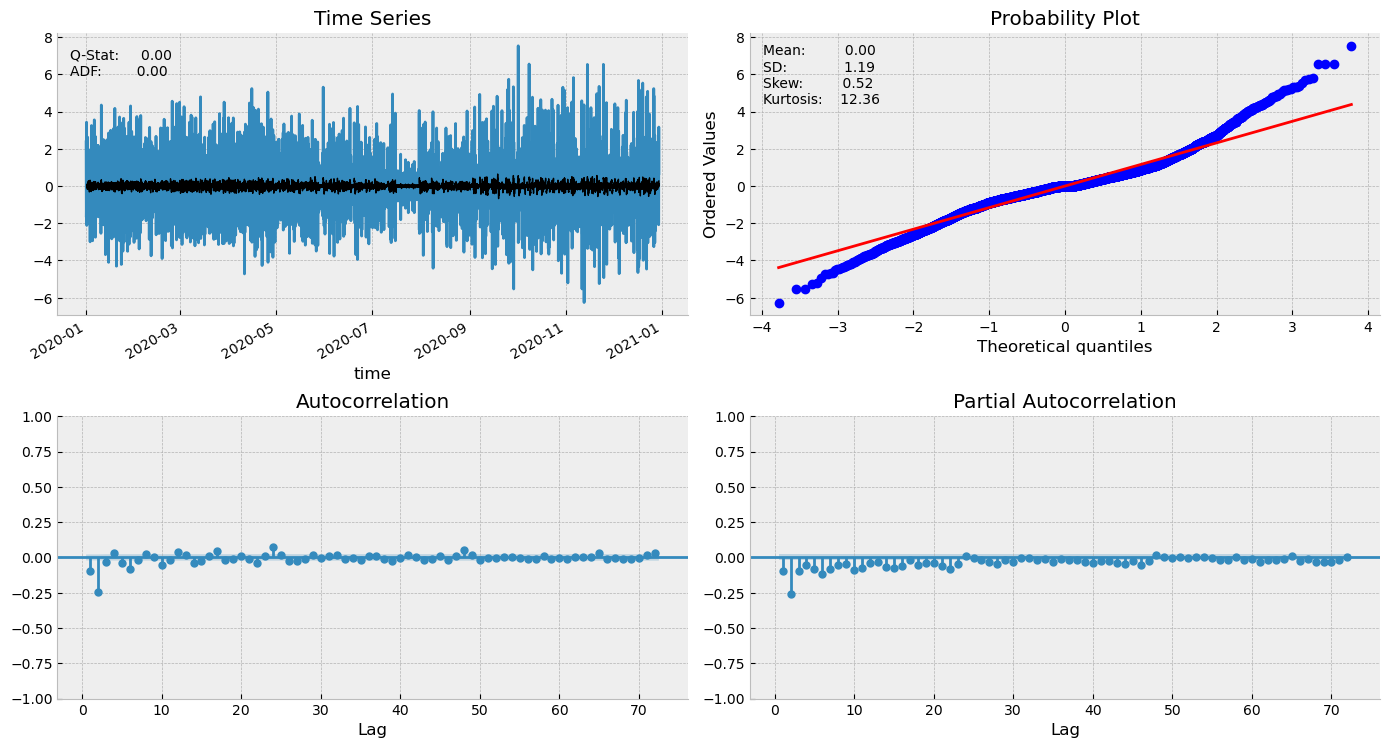

In [43]:
plot_correlogram(df["forward_consumption_48"].diff().dropna(), lags = 72)

## Multivariate EDA

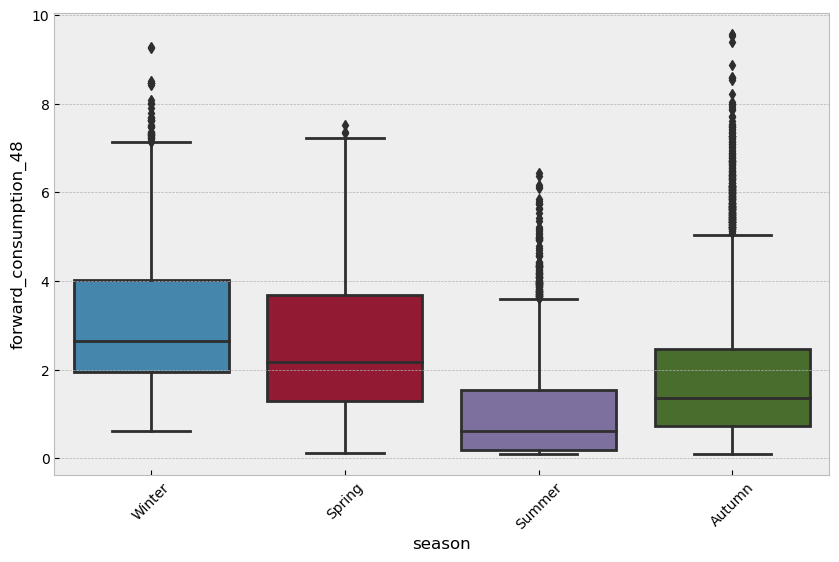

In [41]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='season', y="forward_consumption_48", data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.show()

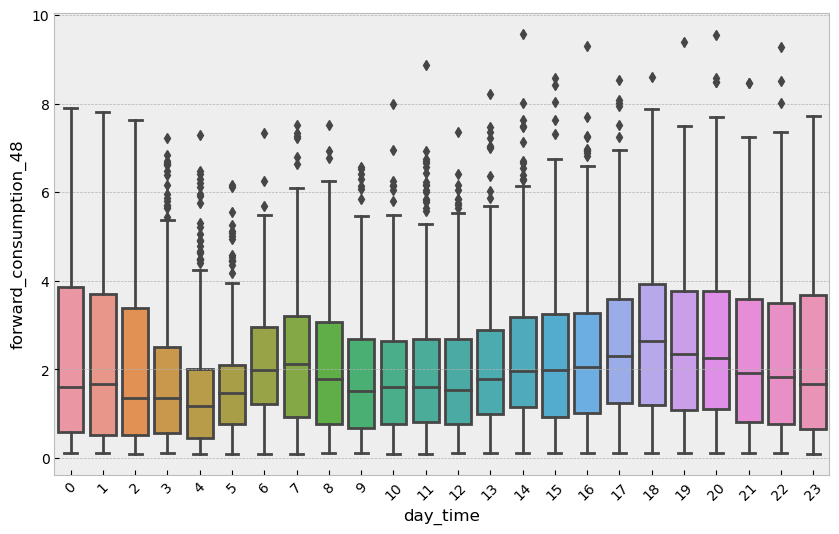

In [40]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='day_time', y="forward_consumption_48", data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.show()

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2020-01-01 00:00:00 to 2020-12-30 00:00:00
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   consumption             8761 non-null   object 
 1   forward_temperature_24  8761 non-null   float64
 2   forward_humidity_24     8761 non-null   float64
 3   forward_cloudiness_24   8761 non-null   float64
 4   day_time                8761 non-null   int64  
 5   season                  8761 non-null   object 
 6   forward_consumption_48  8761 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 547.6+ KB


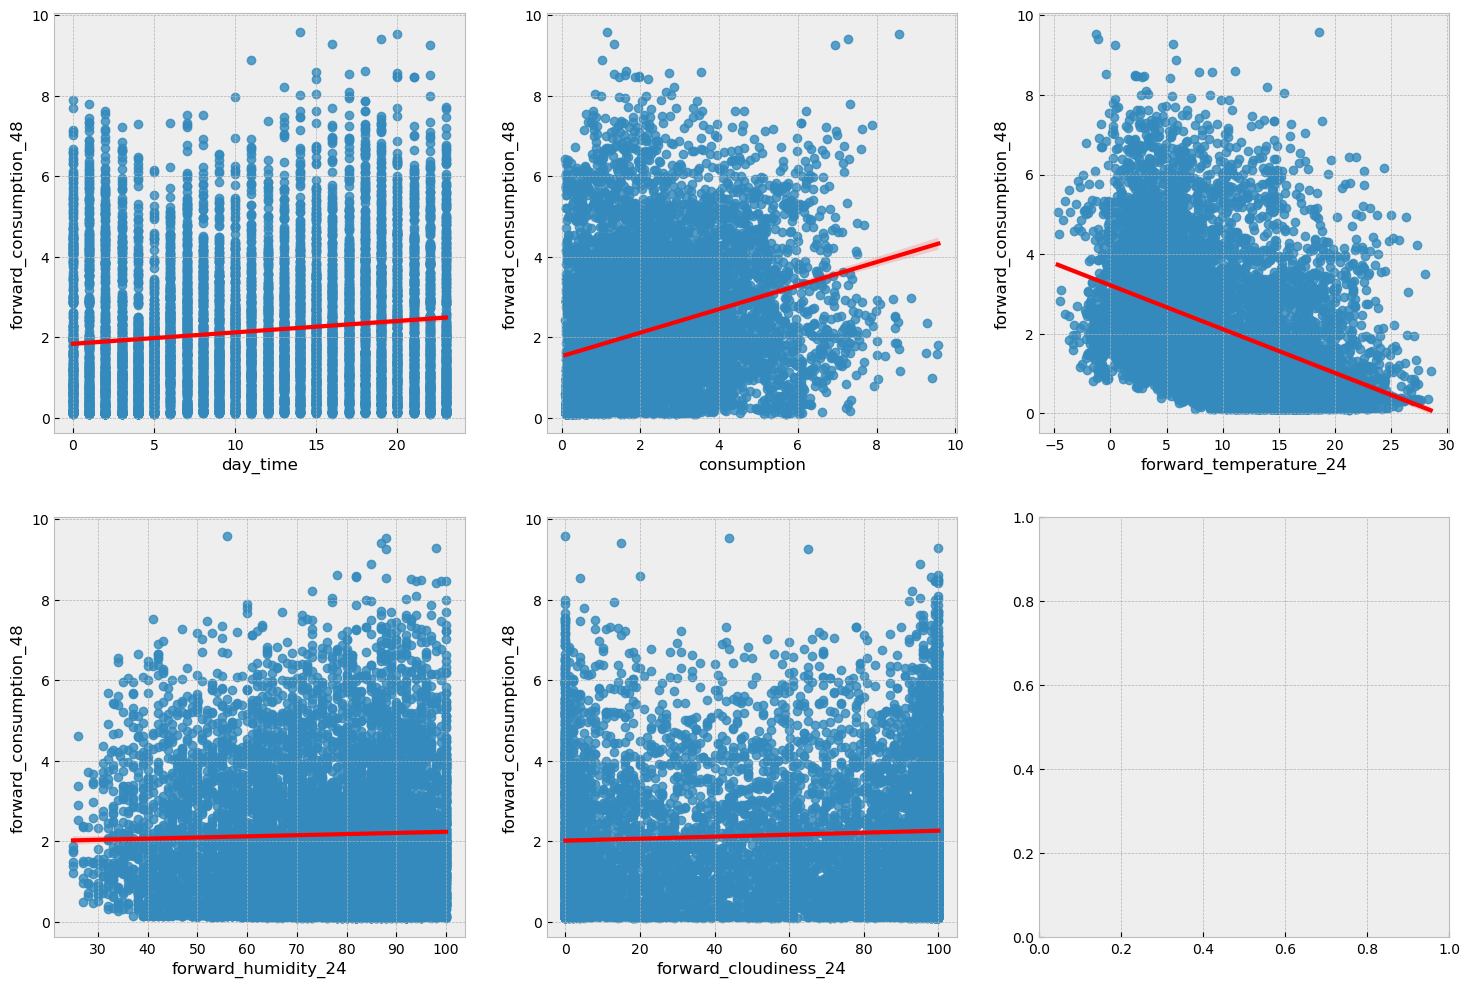

In [103]:
for col in df.columns:
    if col != "season":
        df[col] = df[col].astype(float)
        
features_to_analyse = ['day_time',
                       'consumption',
                       'forward_temperature_24',
                       'forward_humidity_24',
                       'forward_cloudiness_24',
                       'season'
                      ]

# Understand Linear relationship in between target vs features/ Note for lr y-will needed ot be transformed
fig, ax = plt.subplots(2, 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],
                    y='forward_consumption_48',
                    data=df,
                    ax=ax,
                    ci=95,
                    line_kws={"color": "red"},
                    scatter=True,
                    fit_reg=True,
                    n_boot=100)

<AxesSubplot:>

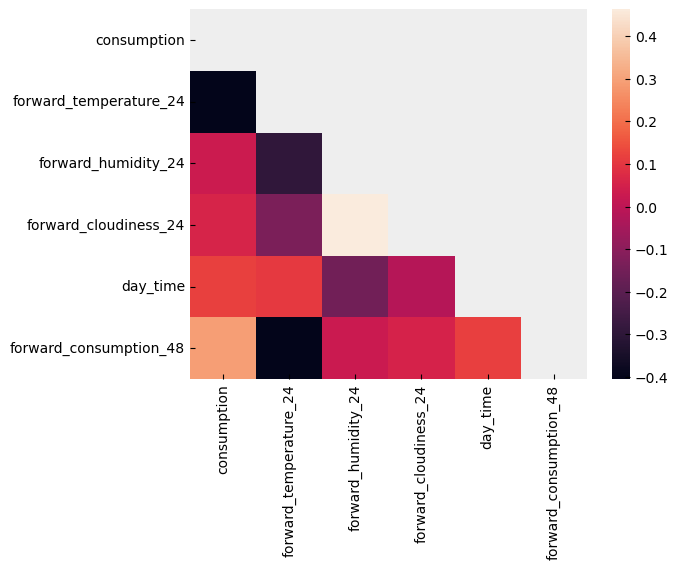

In [104]:
corr = df.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask)

<AxesSubplot:>

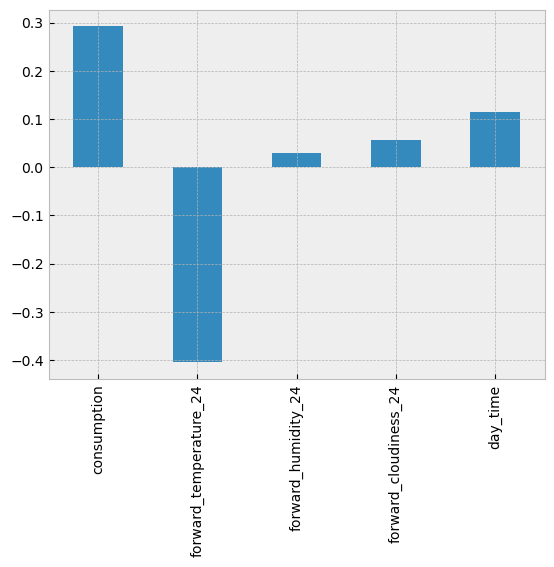

In [105]:
corr = df.corr(method='pearson')
corr['forward_consumption_48'].iloc[:-1].plot.bar()